## Greedy-algorithm

In [113]:
'''***************************************************************'''
# 在 Model_version_05_3 的基础上, 添加了 Model_version+05_5 中优化后的子集生成函数，消除了所有主导集
#  Model_version_05_6
import math
import random
import copy
from tqdm.notebook import tqdm
from os import system
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import datetime
import io
import numpy as np
import numpy


## 将内容同时输出到命令行和文件中去

In [114]:
## 将内容同时输出到命令行和文件中去
import sys
class Logger:
    def __init__(self, file_name):
        self.terminal = sys.stdout  # 保存原始标准输出
        self.log_file = open(file_name, 'a')  # 打开文件，模式为 append

    def write(self, message):
        self.terminal.write(message)  # 打印到控制台
        self.log_file.write(message)  # 写入文件

    def flush(self):
        # 需要 flush 否则可能输出不会实时写入文件
        self.terminal.flush()
        self.log_file.flush()

    def __del__(self):
        # 在文件关闭前，添加额外的内容
        self.log_file.write("\n" + '*' * 150 + "\n" + '*' * 150 + "\n" + '*' * 150 + "\n")  # 添加自定义分隔符或文本
        self.log_file.close()  # 关闭文件

if False:
    sys.stdout = Logger('output') # 将 sys.stdout 重定向到 Logger 实例
## 将内容同时输出到命令行和文件中去 end

''' 记录当前时间 '''
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(now)

2025-05-08 02:42:53


In [115]:
import numpy as np
from scipy.optimize import milp, Bounds
from scipy.optimize import LinearConstraint

## 检验 贪心算法、线性规划法、布尔代数法、概率随机法之间的效率

#### 程序介绍：
1. 生成一个对于全集 $N$ 的随机数目的随机元素数目子集集合（子集族 $F$）
2. 对该集合采用多种算法, 并评估他们的算法速度

#### 线性规划法 , 布尔代数法  与  概率随机法
* Full_set 需要自己定义
* 注意! 子集中不能出现空集

## 设定全集大小，以及循环次数


In [ ]:
N = 100
M = 300  

### 定义子集生成函数

In [117]:
full_set = list(range(1, N+1))
if len(full_set) < 500:
    print('len(full_set):', len(full_set))
    print('full_set:', full_set)

def check_subset(set_A: set, subsets):  # 检查一个子集 set_A 是否覆盖了 subsets
    for subset in subsets:
        if set_A.isdisjoint(set(subset)):
            return False
    return True

def generate_random_subsets(full_set):  # 待改进：生成的子集集合中存在相同集合
                                        # 已改进：产生的集合中不会出现空集
                                        # 已改进：产生的集合中将不会出现相同子集 (2024/12/12)
                                        # 已改进：不会生成长度为 1 的子集（2024/12/26）
                                        # 已改进：消除掉集合中所有主导集（2024/12/26）
    # num_subsets = random.randint(1, pow(2, len(full_set)))    # Random number of subsets
    # num_subsets = random.randint(1, 15 * len(full_set))
    # num_subsets = random.randint(1, 2 * len(full_set))
    num_subsets = random.randint(1, 15)
    # num_subsets = random.randint(1, 5 * len(full_set))
    subsets = []
    for _ in range(num_subsets):
        flag_found = False
        while flag_found == False:
            subset_size = random.randint(2, len(full_set))  # Random subset size
            new_subset = random.sample(full_set, subset_size)  # Random subset
            new_subset = sorted(new_subset)  # 将子集元素排序
            # 如果 new_subset 并未出现在之前的子集中
            flag_found = True
            for element in subsets:
                # 如果 new_subset 为某集合的主导集则同样也跳过
                if new_subset == element or set(element).issubset(new_subset):
                    flag_found = False
                    break
            if flag_found == True:
                subsets.append(new_subset)
    # print('first step subsets:')
    # print(subsets)  # 进行主导集消除前的子集组
    # 最后去除掉主导其他子集的集合
    for element in subsets[:]:
        for other_element in subsets[:]:
            if element == other_element:
                continue
            elif set(other_element).issubset(element):
                subsets.remove(element)
                break
    # print('num_subsets:', len(subsets))
    return subsets

len(full_set): 100
full_set: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


## 将各种计算方法包装成函数，在大循环中调用他们

### 贪心算法：

In [118]:
def Algo_Greedy( subsets ):
    # print('贪心算法开始')
    len_full_set = len(full_set)
    # 现在我们需要将生成的子集格式转换成我们算法中的规范格式(矩阵格式)
    matrix_subsets = []
    for subset in subsets:
        matrix_subset = [0] * len_full_set
        for element in subset:
            matrix_subset[element - 1] = 1
        matrix_subsets.append(matrix_subset)
    # print('matrix_subsets ready')
    # 规范格式下的子集集合的格式(例): [[0, 1, 0, 1, 0], [1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
    ''' ！！现在, 我们拥有了规范形式的子集集合！ '''
    ''' 接下来, 我们的算法是：
        1. 找到矩阵中元素值为 1 最多的一列
        2. 去除此列并将该列中值为 1 的子集(行)去除
        3. 重复 1 、 2                        '''
    
    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []                     # 记录每一次覆盖时的信息

    while matrix_subsets != []:     # 找出一个 представитель
        record_current_step = []
        counter += 1
        # 1).
        matrix_subsets = numpy.array(matrix_subsets)

        list_index_record = list_index.copy()
        record_current_step.append(list_index_record)
        record_current_step.append(matrix_subsets)
        record.insert(0, record_current_step)
        sum_column = matrix_subsets.sum(axis=0)
        ''' 这里当有多个最大值时，会返回 idx 最小的最大值 '''
        idx_max = np.argmax(sum_column)     # 元素值为 1 最多的一列的 index (由 0 开始)
                                            # 这里将会找到最大值的 index, 当有多个最大值时, 会返回最小的 index
        # 1).
        # 2).
        current_column = matrix_subsets[:, idx_max]
        '''
        1. 删除掉矩阵里相应的 current_column 中值为 1 的序号的行
        2. 删除掉 idx_max 列
        3. 将 idx_max 保存下来作为最小集合成员
        具体实施方法：
        a, 将 current_column 中值为 0 的列添加入新的矩阵(列表)中,
        b, 在新的矩阵中删除每个元素的第 idx_max 元素
        注：a, b 可在同一个循环内进行
        '''
        new_matrix_subsets = []
        for i in range(len(current_column)):
            if current_column[i] == 0:
                new_subset = (matrix_subsets[i,:]).tolist()
                new_subset.pop(idx_max)     # 去除掉第 idx_max 项
                new_matrix_subsets.append(new_subset)
        matrix_subsets = new_matrix_subsets

        set_representative.append(list_index.pop(idx_max.tolist()))
    # print('set_representative:', set_representative)    # ！！初步计划已经完成！！
    set_representative_copy = set_representative.copy()

    # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    '''现在，我们有了 record 和 Greedy 算法得出的结果，我们可以进行检验了'''
    # print('*******************************************************************************************************')

    set_representative_checked = []     # 检验过后的代表集合
    for step in record:
        check_vector = [0] * len(step[0])
        po = set_representative.pop()
        for element in set_representative_checked:
            for idx, value in enumerate(step[0]):
                if value == element:
                    check_vector[idx] = 1
                    break

        flag_add_element = np.any(0 == np.dot(step[1], np.array(check_vector)))
        # 在这里判断是否添加 po 元素进入 set_representative_checked 中
        if flag_add_element:
            set_representative_checked.insert(0, po)
    # print()
    # print('最终结果:')
    # print('set_representative_copy:')
    # print(set_representative_copy)
    # print('set_representative_checked:')
    # print(set_representative_checked)
    # print()
    set_representative_copy.sort()
    set_representative_checked.sort()
    # print('set_representative_copy with offset:')
    # print([x - 1 for x in set_representative_copy])
    # print('set_representative_checked with offset:')
    # print([x - 1 for x in set_representative_checked], '    min len:', len(set_representative_checked))
    minlen_greddy_algo = len(set_representative_checked)
    # print('贪心算法结束')
    return minlen_greddy_algo


### 贪心算法2.0：（尚未实现）


##### 辅助函数

In [119]:
''' 检查矩阵的某一列是否是 主导元 '''
def check_has_dominant(matrix, column_idx):
    
    sum_matrix = np.sum(matrix, axis=0)
    print( sum_matrix )
    print()
    flag_has_dominant = False
    rows = matrix[matrix[:, column_idx] == 1]
    print(rows)
    
    for row in rows:
        row_copy = row.copy()
        row_copy[column_idx] = 0    ## 忽略 column_idx 位，相当于跳过
        print('row_copy:', row_copy)

        sum_matrix_mask = sum_matrix[row_copy == 1]

        # check = np.all(np.sum(matrix, axis=0)[row_copy == 1] == 1)
        check = np.all(sum_matrix[row_copy == 1] == 1)
        print(check)

        print( 'sum_matrix_mask:',  sum_matrix_mask)
        print( 'sum_matrix_mask.size:',  sum_matrix_mask.size)
        if check and sum_matrix_mask.size > 0:  
            return True
    return False

def check_has_dominant(matrix, column_idx):
    sum_matrix = np.sum(matrix, axis=0)
    rows = matrix[matrix[:, column_idx] == 1]       ## 这里的 rows 是一个浅拷贝
    rows[ : , column_idx] = 0                       ## 一次性将 column_idx 列置为 0
    
    for row in rows:

        sum_matrix_mask = sum_matrix[row == 1]
        if sum_matrix_mask.size == 0:
            continue
        check = np.all(sum_matrix_mask == 1)

        if check:
            return True
    return False
    

test_matrix_1 = [
    [1,1,0,0,0,0],
    [1,0,1,0,1,0],
    [0,0,1,0,0,1],
    [0,1,0,1,0,0]
]
test_matrix_2 = [
    [1,0,1,0,0],
    [0,1,0,0,1],
    [1,1,0,0,0],
    [0,0,1,1,0]
]
test_matrix_3 = [
    [0,0,0,1,1,1],
    [1,1,0,0,0,0],
    [0,1,1,0,0,0],
    [1,0,1,1,0,0]
]
test_matrix_4 = [
    [0,1,0,0,0,1],
    [1,0,1,0,0,0],
    [1,1,0,0,1,0],
    [0,0,1,1,0,0]
]
test_matrix_5 = [
    [1,0,1,0,0,0],
    [0,1,0,1,0,1],
    [0,0,1,1,0,0],
    [1,0,0,1,0,1],
    [0,1,1,0,0,0],
    [1,1,0,0,0,1]
]
test_matrix_6 = [
    [1,1,0,0,0,0],
    [1,0,1,0,1,0],
    [0,0,1,0,0,0],
    [0,1,0,1,0,0]
]
assert check_has_dominant(np.array(test_matrix_1), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_1), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_1), 3 - 1) == True
assert check_has_dominant(np.array(test_matrix_1), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_1), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_1), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_2), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_2), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_2), 3 - 1) == True
assert check_has_dominant(np.array(test_matrix_2), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_2), 5 - 1) == False

assert check_has_dominant(np.array(test_matrix_3), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 2 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 3 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 4 - 1) == True
assert check_has_dominant(np.array(test_matrix_3), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_3), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_4), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_4), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_4), 3 - 1) == True
assert check_has_dominant(np.array(test_matrix_4), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_4), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_4), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_5), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 2 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 3 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_5), 6 - 1) == False

assert check_has_dominant(np.array(test_matrix_6), 1 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 2 - 1) == True
assert check_has_dominant(np.array(test_matrix_6), 3 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 4 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 5 - 1) == False
assert check_has_dominant(np.array(test_matrix_6), 6 - 1) == False


# print('Result:', result)

## 贪心算法循环递归函数

In [ ]:
def greedy_core( matrix_subsets, record, set_representative ):  ## matrix_subsets: list

    while matrix_subsets != []:
        
        pass

In [ ]:
def Algo_Greedy20( subsets ):
    ''' 验证结果的方法: 
    1. 判断是否是 Hitting Set, 即是否与子集族F的每个子集S都有交点;
    2. 检查结果的长度是否与 LinearProgramming 的结果相同或接近 '''
    # print('贪心算法开始')
    len_full_set = len(full_set)
    # 现在我们需要将生成的子集格式转换成我们算法中的规范格式(矩阵格式)
    matrix_subsets = []
    for subset in subsets:
        matrix_subset = [0] * len_full_set
        for element in subset:
            matrix_subset[element - 1] = 1
        matrix_subsets.append(matrix_subset)
    # 规范格式下的子集集合的格式(例): [[0, 1, 0, 1, 0], [1, 0, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 1, 1], [0, 1, 1, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
    ''' ！！现在, 我们拥有了规范形式的子集集合！ '''
    ''' 接下来, 我们的算法是：
        1. 找到矩阵中元素值为 1 最多的一列
        2. 去除此列并将该列中值为 1 的子集(行)去除
        3. 重复 1 、 2                        '''
    
    list_index = full_set.copy()    ## full_set 不涉及嵌套结构，普通copy()已经足够 ## 每次选出最大值时, 将这里面的值删除并加入到 set_representative 里
    set_representative = []         # Множество представителей; Hitting Set
    counter = 0
    record = []                     # 记录每一次覆盖时的信息

    while matrix_subsets != []:     # 找出一个 представитель
        record_current_step = []
        counter += 1
        # 1).
        matrix_subsets = np.array( matrix_subsets )

        list_index_record = list_index.copy()
        record_current_step.append(list_index_record)
        record_current_step.append(matrix_subsets)
        record.insert(0, record_current_step)           # 插入到 record 队列前部
        sum_column = matrix_subsets.sum(axis=0)         # axis=0, 列求和
        ''' 这里当有多个最大值时，会返回 idx 最小的最大值 '''
        ''' 这里需要修改为支持有多个最大值的情况 '''
        idx_max = np.argmax(sum_column)                 # 元素值为 1 最多的一列的 index (由 0 开始)
                                                        # 这里将会找到最大值的 index, 当有多个最大值时, 会返回最小的 index
        # 1).
        # 2).
        current_column = matrix_subsets[:, idx_max]     # 本轮删除的列
        '''
        1. 删除掉矩阵里相应的 current_column 中值为 1 的序号的行
        2. 删除掉 idx_max 列
        3. 将 idx_max 保存下来作为最小集合成员
        具体实施方法：
        a. 将 current_column 中值为 0 的列添加入新的矩阵(列表)中,
        b. 在新的矩阵中删除每个元素的第 idx_max 元素
        注: a, b 可在同一个循环内进行
        '''
        new_matrix_subsets = []
        for i in range(len(current_column)):
            if current_column[i] == 0:
                new_subset = (matrix_subsets[i,:]).tolist()
                new_subset.pop(idx_max)     # 去除掉第 idx_max 项
                new_matrix_subsets.append(new_subset)
        matrix_subsets = new_matrix_subsets

        print('type(matrix_subsets):', type(matrix_subsets))

        set_representative.append(list_index.pop(idx_max.tolist()))
    # print('set_representative:', set_representative)    # ！！初步计划已经完成！！
    set_representative_copy = set_representative.copy()

    # print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    '''现在，我们有了 record 和 Greedy 算法得出的结果，我们可以进行检验了'''
    # print('*******************************************************************************************************')

    set_representative_checked = []     # 检验过后的代表集合
    for step in record:
        check_vector = [0] * len(step[0])
        po = set_representative.pop()
        for element in set_representative_checked:
            for idx, value in enumerate(step[0]):
                if value == element:
                    check_vector[idx] = 1
                    break

        flag_add_element = np.any(0 == np.dot(step[1], np.array(check_vector)))
        # 在这里判断是否添加 po 元素进入 set_representative_checked 中
        if flag_add_element:
            set_representative_checked.insert(0, po)

    # print()
    # print('最终结果:')
    # print('set_representative_copy:')
    # print(set_representative_copy)
    # print('set_representative_checked:')
    # print(set_representative_checked)
    # print()
    set_representative_copy.sort()
    set_representative_checked.sort()
    # print('set_representative_copy with offset:')
    # print([x - 1 for x in set_representative_copy])
    # print('set_representative_checked with offset:')
    # print([x - 1 for x in set_representative_checked], '    min len:', len(set_representative_checked))
    minlen_greddy_algo = len(set_representative_checked)
    # print('贪心算法结束')
    return minlen_greddy_algo

### 离散线性规划法：（最强方法，瞬间出正确结果，作为基准使用）

In [122]:
def Algo_LinearProgramming( subsets ): 
    # print('线性规划法开始')
    num_full_set = len(full_set)
    # print(full_set)
    num_subsets = len(subsets)
    '''目标: 将子集转化为离散线性优化问题   已完成'''
    c = np.array([1] * num_full_set)
    integrality = np.array([1] * num_full_set)                     # 整数
    bounds = Bounds([0] * num_full_set, [1] * num_full_set)
    def parser(num_full_set, ele):
        arr = [0] * num_full_set
        for i in ele:
            arr[i - 1] = 1
        return arr
    A_array, res_2 = [], []
    for ele in subsets:
        A_array.append(parser(num_full_set, ele))
    # print('A_array:', A_array) # Amazing!
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)   # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界

    constraints = LinearConstraint(A, b_l, b_u)

    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    # print('Array Result:', res.x)
    # res_2 = []
    for idx, var in enumerate(res.x):
        # if var == 1.:
        if math.isclose(var, 1.):
            res_2.append(idx)
    # print('Array Result 2: ', res_2, len(res_2))
    minlen_int_linear_prog = len(res_2)
    # print('线性规划法结束')
    return minlen_int_linear_prog

### 布尔代数法：


In [123]:
from pyeda.inter import *
import pyeda

def Algo_BooleanAlgebra( subsets ):

    print('布尔代数法开始')
    '''构造布尔化简方法解'''
    x = exprvars('x', len(full_set))
    # print(x)
    
    '''子集组列表，由generate_random_subsets()函数生成'''
    
    '''**************************************************************************'''
    '''将子集组转化成布尔表达式'''
    f1 = 1
    print('num_subsets:', len(subsets))
    for subset in tqdm(subsets):
        f2 = 0
        for element in subset:
            f2 = espresso_exprs((f2 | x[element - 1]).to_dnf())[0]
        f1 = espresso_exprs((f1 & f2).to_dnf())[0]
    
    # print('f1:', f1)
    boolean_function = espresso_exprs(f1.to_dnf())[0]
    # print(boolean_function)
    '''从简化后的表达式中挑选出长度最短的项'''
    # print('boolean_function:', boolean_function, type(boolean_function))
    if (type(boolean_function) != pyeda.boolalg.expr.Variable):
        boolean_function = boolean_function.xs
        min_length = boolean_function[0].degree
        str_result = ''  # 存储所有最短的 ДНФ 项
        count = 0
        for i in boolean_function:
            # print('count:', count, '\t', i, i.degree, min_length)
            count += 1
            if type(i) == pyeda.boolalg.expr.AndOp:  # 通常情况下最短元素将会是这种情况
                if i.degree < min_length:
                    min_length = i.degree
                    str_result = str(i.xs)
                elif i.degree == min_length:
                    str_result += ' ' + str(i.xs)
            elif type(i) == pyeda.boolalg.expr.Variable:
                if min_length == 1:
                    str_result += ' (' + str(i) + ')'
                else:
                    min_length = 1
                    str_result = '(' + str(i) + ')'
    else:
        str_result = '(' + str(boolean_function) + ')'
    print('String Result:', str_result)
    print('布尔代数法结束')

### 随机概率法：

In [124]:
def Algo_RandomProbability( subsets ):
    print('概率随机法开始')
    num_full_set = len(full_set)
    num_subsets = len(subsets)
    '''目标: 计算出相应条件下的连续离散优化问题, 其中取值范围为[0, 1]'''
    c = np.array([1] * num_full_set)    # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)                     # 实数变量
    bounds = Bounds([0] * num_full_set, [1] * num_full_set)        # 变量取值边界 (在这个例子里为 0~1之间概率)
    def parser(num_full_set, subset):              # 辅助函数
        arr = [0] * num_full_set
        for i in subset:
            arr[i - 1] = 1
        return arr
    A_array = []
    for i in subsets:                              # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)   # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    print('Array Result:', res.x)       # 获取到了每个概率属于最优解的理论概率
    '''接下来我们进行 N 次猜测: 以 res.x值作为概率确定每个值是否被选中, 并判断得出子集是否满足条件. 最终进行比较, 找到最小的子集'''
    N = 100000    # 进行循环猜测的次数
    '''！！！！！还需要添加的部分: 需要统计在 N 次中, 有多少次不满足要求, 即实际失败率约为多少！！！'''
    min_set = []
    flag_find = False
    for i in tqdm(range(N)):
        try_set = []
        len_try_set = 0
        for probability in res.x:
            if probability == 1:
                try_set.append(1)
                len_try_set += 1
            elif random.uniform(0, 1) < probability:  # 随机生成一个0到1之间的数, 判断他是不是小于 probability
                try_set.append(1)
                len_try_set += 1
            else:
                try_set.append(0)
        test_set, test_set_2 = [], []
        for idx, var in enumerate(try_set):
            if var == 1:
                test_set.append(idx + 1)
                test_set_2.append(idx)
        test_set = set(sorted(test_set))
        test_set_2 = set(sorted(test_set_2))
        len_min_set = num_full_set
        '''检测 try_set [] 是否能够满足这个集合'''
        # print(test_set, len_try_set)
        if check_subset(test_set, subsets):
            flag_find = True
            if len(min_set) == 0:
                min_set.append(sorted(test_set_2))
                len_min_set = len(test_set_2)
            elif len(test_set) < len_min_set:
                len_min_set = len(test_set_2)
                min_set = []
                min_set.append(sorted(test_set_2))
            elif len(test_set) == len_min_set:
                flag = True
                for i in min_set:
                    # print('XXX:', i, test_set_2, i == test_set_2)
                    if i == test_set_2:
                        flag = False
                        break
                if flag:
                    min_set.append(sorted(test_set_2))
    if flag_find:
        print('min_set:', min_set, 'min_len:', len_min_set)
    else:
        print('min_set:', min_set, 'Not find!')
    print('概率随机法结束')

## 循环多次进行检验

In [ ]:
# 对整体进行多次循环, 找到所有较好的例子

greedy_algo_donot_work = []                 # 贪心算法无法找到最小解
greedy_algo_donot_work_difference = []      # 贪心算法无法找到最小解时与最小解的差距
size_of_mini_set = []                       # 统计最小集合的 size
ratio_mini_set_of_greedy = []               # 最优解 / Greedy 算法解
minlen_greddy_algo = 0
minlen_int_linear_prog = 0
for _ in tqdm(range(M)):                    
    ''' 生成子集族 '''
    subsets = generate_random_subsets(full_set)
    ''' 保留 subsets 的深拷贝，用于检验算法是否修改了 subsets '''
    subsets_COPY = copy.deepcopy(subsets)

    # subsets = [[1, 2, 5], [1, 3], [1, 4], [4, 5], [3, 5], [2, 3, 5]]
    # subsets = [[1, 2, 3, 4, 5, 6], [3], [1, 2, 3, 6], [3, 4, 6], [1, 2, 3, 4, 6]]     # error
    # subsets = [[1, 2, 5, 6], [1, 3, 4, 6], [1, 2, 3, 4, 5, 6], [1, 4], [], [], [1, 3, 5, 6], [1, 2, 3, 4, 5], [4, 5], [], [1, 2, 3, 4, 5, 6], [4], [1, 2], []]    # error
    # subsets = [[]]  # error
    # subsets = [[1, 3, 4, 5, 6], [3, 4], [2, 3, 4, 5, 6], [1, 2, 3, 4, 5], [4], [1], [2], [1, 3, 5], [2, 3, 4, 5, 6], [1, 2, 4, 5, 6], [1, 3], [1, 2, 4, 6], [1, 2, 3, 4, 5, 6]] # slow
    # subsets = [[1, 3, 4, 5], [1, 2, 3, 4, 5, 6], [4], [1, 2, 3, 4, 5, 6], [1, 2, 5, 6], [1, 2, 3, 5, 6], [2, 3, 4, 5, 6], [2, 3], [2, 4], [1, 2, 3, 4, 5], [3, 4, 5, 6], [1, 6], [2], [1, 2, 3, 4, 5], [1, 3, 4]] # slow

    # n = 6 时贪心算法找不到最小值的例子：
    # 20: subsets = [[1, 2, 4, 5, 6], [1], [3], [1, 2, 3, 5, 6], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [2, 4, 6], [1, 3, 5], [1, 3, 4, 5, 6], [2, 3, 4, 5, 6], [1, 2, 3], [2, 3, 5], [4, 6], [1, 2, 3, 5], [4, 5, 6], [2], [1, 2, 4], [2, 3, 4, 6], [1, 2, 3, 6], [2, 4, 5, 6], [1, 2, 4, 5], [5, 6], [3, 6], [2, 4], [3, 5, 6], [1, 5]]
    # 9: subsets = [[2, 6], [4, 5], [1, 3, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 4, 5], [1, 2, 3, 5, 6], [2, 4], [1, 6], [2, 5, 6]]
    # 20: subsets = [[4], [1, 3, 4, 5, 6], [1, 3, 6], [4, 5, 6], [3, 6], [3, 5, 6], [1, 2, 3, 4, 5, 6], [2, 3, 4], [5], [3, 4, 5, 6], [1, 2, 3, 5], [1, 3, 5], [2, 3, 4, 6], [1, 2, 3, 4, 5], [2, 4, 5], [3, 4, 5], [1, 2, 3, 4, 6], [2, 6], [1, 2, 3, 5, 6], [2, 4, 6]]


    # print('subsets =', subsets)

    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Random probability
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Greedy 
    minlen_greddy_algo = Algo_Greedy( subsets )
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Linear programming  返回代表集最小长度
    minlen_int_linear_prog = Algo_LinearProgramming( subsets )
    '''*********************************************************************************************************************'''
    '''*********************************************************************************************************************'''
    ## Boolean algebra
    # '''**************************************************************************'''
    '''*********************************************************************************************************************'''
    
    ''' 如果整数线性优化结果小于贪心算法, 那么将当前 subsets 添加进库 '''
    if minlen_int_linear_prog < minlen_greddy_algo:
        greedy_algo_donot_work.append(subsets)
        greedy_algo_donot_work_difference.append( minlen_greddy_algo - minlen_int_linear_prog )
    size_of_mini_set.append( minlen_int_linear_prog ) # 记录每次的最优解集合大小
    ratio_mini_set_of_greedy.append( minlen_int_linear_prog / minlen_greddy_algo )

    ''' 如果 subsets 被修改，立刻报错!!! '''
    assert subsets_COPY == subsets       
    
lenth_list = [len(i) for i in greedy_algo_donot_work]
sorted_first_10_list = sorted(greedy_algo_donot_work, key=len)[:10]  # 排序后长度最短的 10 个

print('sorted_list:')
print(sorted_first_10_list)
print('M:', M)
print('min length:', min(lenth_list), '     percent of not work:', len(greedy_algo_donot_work) / M, f'({100 * len(greedy_algo_donot_work) / M}%)')
print('number of not work:', len(greedy_algo_donot_work))




  0%|          | 0/300 [00:00<?, ?it/s]

type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
type(matrix_subsets): <class 'list'>
t

# 进行频率统计

In [126]:
## 进行频率统计
print('总数:', M)
counter = Counter(greedy_algo_donot_work_difference)
print('greedy_algo_donot_work_difference\n贪心算法与最优解差值:', counter)
counter = Counter(size_of_mini_set)
print('size_of_mini_set\n最优解大小统计:', counter)
counter = Counter(ratio_mini_set_of_greedy)
print('ratio_mini_set_of_greedy \n对不同比率进行统计: ', counter)
total = sum(counter.values())
proportions = {k: v / total for k, v in counter.items()}
print('所占比重:', proportions)
print('min(ratio_mini_set_of_greedy) \n最小比率:', min(ratio_mini_set_of_greedy), '   次数：',counter[min(ratio_mini_set_of_greedy)])

总数: 300
greedy_algo_donot_work_difference
贪心算法与最优解差值: Counter({1: 27})
size_of_mini_set
最优解大小统计: Counter({2: 149, 1: 98, 3: 48, 4: 5})
ratio_mini_set_of_greedy 
对不同比率进行统计:  Counter({1.0: 273, 0.6666666666666666: 15, 0.75: 10, 0.8: 2})
所占比重: {1.0: 0.91, 0.6666666666666666: 0.05, 0.75: 0.03333333333333333, 0.8: 0.006666666666666667}
min(ratio_mini_set_of_greedy) 
最小比率: 0.6666666666666666    次数： 15


# 绘制图像

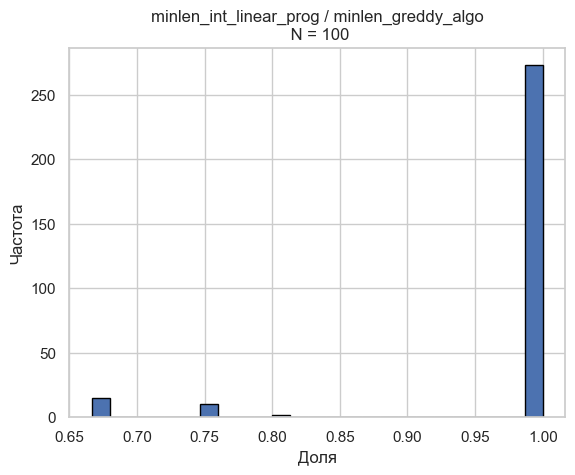

In [127]:
## 打印频率统计图：
# 设置 Seaborn 风格
sns.set(style="whitegrid")
plt.hist([x for x in ratio_mini_set_of_greedy if x <= 1], bins=25, edgecolor='black')  # bins 是分箱数量
plt.title(f'minlen_int_linear_prog / minlen_greddy_algo\n N = {len(full_set)}')
# plt.xlabel('Разница')
plt.xlabel('Доля')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [128]:
# ## 打印频率统计图：
# # 设置 Seaborn 风格
# sns.set(style="whitegrid")
# # plt.hist(greedy_algo_donot_work_difference, bins=10, edgecolor='black')  # bins 是分箱数量
# plt.hist(size_of_mini_set, bins=10, edgecolor='black')  # bins 是分箱数量
# plt.title(f'Оптимальный размер мини множеств представителей\n N = {len(full_set)}')
# # plt.xlabel('Разница')
# plt.xlabel('Размер')
# plt.ylabel('Частота')
# plt.grid(True)
# plt.show()